# Demo:  Writing Custom Transforms

We have seen that, in many cases, we combine linear regression with a pre-processing step to transform the data into features that we may be able to get a better fit.  In this demo, we show the best practices for writing transforms and combining them with linear regression.  Specifically, you will learn to:

*  Define a custom `transform` function for your data.
*  Combine the transform function with model validation.
*  Create a *trainable* transform class.
*  Combine the trainable class with model validation.

We first import the standard packages.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

##  Loading the Data

In this demo, we will load a simple synthetic dataset from NIST which has a set of examples for nonlinear regression.

In [86]:
url = 'https://www.itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Gauss1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y','x'])
df.head()

,y,x
0,97.62227,1.0
1,97.80724,2.0
2,96.62247,3.0
3,92.59022,4.0
4,91.23869,5.0


We can plot the relation between `x` and `y` and we see that the relation is nonlinear.  

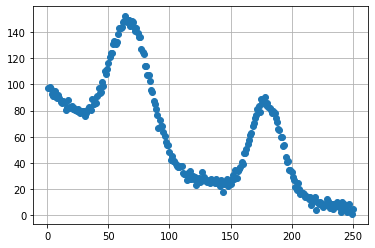

In [87]:
x = np.array(df['x'])
y = np.array(df['y'])
plt.plot(x,y,'o')
plt.grid()

To make the fitting problem a little more challenging, I am going to keep only 100 samples.

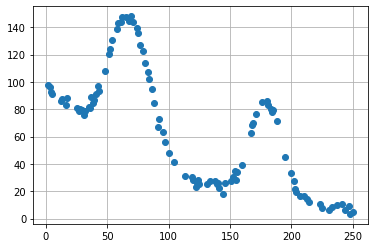

In [88]:
ns = len(x)
nred = 100
I = np.random.permutation(ns)
x = x[I[:nred]]
y = y[I[:nred]]

plt.plot(x,y,'o')
plt.grid()

For the remainder of the demo, we will use the following training and test split.

In [89]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr, xts, ytr, yts = train_test_split(x,y,test_size=0.33)

## Writing a Transform

From the plot, we see that the relation between `x` and `y` is nonlinear and a simple linear model of the form `yhat = w*x + b` will not work well.  One possible alternate model is called the *Discrete Cosine Transform* which is something like the Fourier basis for non-periodic functions.  The DCT model is:

    yhat = \sum_{j=0}^{d-1}  w[j]*cos( pi*j*x/xper)
    
where we would learn the coefficients `w[j]` from the data.  For now, the parameter `xperiod` is fixed. This is equivalent to a linear model with the basis functions,  `cos( pi*j*x/xperiod)`.  

To implement the fitting with a set of basis functions, the common practice is to first write a `transform` function that takes the data matrix `X` with `n` and output a transformed matrix `Z` also with `n` rows.  In this case, the transformed output will have `d` rows.  We can implement this as follows:

In [90]:
def dct_transform(x,d,xperiod):
    n = len(x)
    Z = np.zeros((n,d))
    for j in range(d):
        Z[:,j] = np.cos(np.pi*x*j/xperiod)
        
    return Z

You can also write the transform with python broadcasting.

In [91]:
def dct_transform(x,d,xperiod):
    drange = np.arange(d)
    Z = np.cos(np.pi*x[:,None]*drange[None,:]/xperiod)        
    return Z

We can now perform the fit easily by transforming the training and test.  For example, if we want to fit with a `d=10` order model:

In [92]:
d = 10
xperiod = 250
Ztr = dct_transform(xtr,d,xperiod)
Zts = dct_transform(xts,d,xperiod)

reg = LinearRegression()
reg.fit(Ztr,ytr)
yhat = reg.predict(Zts)

rsq = r2_score(yts,yhat)
print(rsq)


0.9776159036561226


We can plot the predictions over all data points as follows:

(0, 250)

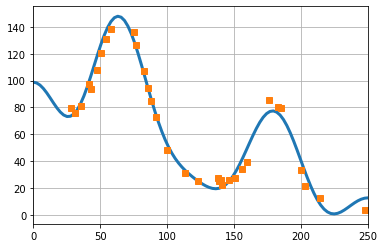

In [93]:
xp = np.linspace(0,250,100)
Zp = dct_transform(xp,d,xperiod)
yp = reg.predict(Zp)

plt.plot(xp, yp, '-', lw=3)
plt.plot(xts, yts, 's')
plt.grid()
plt.xlim([0,250])

## Combining Transforms with Model Validation

We can easily put the transform into a standard model validation loop.

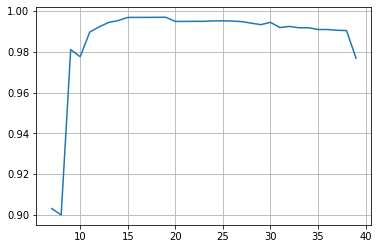

In [94]:
dtest = np.arange(7,40).astype(int)
ntest = len(dtest)
rsq = np.zeros(ntest)

# Loop over model orders
for i, d in enumerate(dtest):
    
    # Transform training and test
    xperiod = 250
    Ztr = dct_transform(xtr,d,xperiod)
    Zts = dct_transform(xts,d,xperiod)
    
    # Fit on training    
    reg = LinearRegression()
    reg.fit(Ztr,ytr)
    
    # Score on the test    
    yhat = reg.predict(Zts)
    rsq[i] = r2_score(yts,yhat)
    
plt.plot(dtest, rsq)
plt.grid()


## Writing Trainable Transforms

In some cases the transform will have parameters that you want to learn from the data.  For this purpose, the custom is to write a class with four methods:

*  `__init__`:  The constructor.  Here, you enter any fixed parameters.
*  `fit`:  Fits the parameters from training
*  `transform`:  Transforms the data using the learned parameters
*  `fit_transform`:  Performs fit and transform.

For example, the following class learns the parameter `xperiod` from the range of the data. 

In [95]:
class DCTTrans(object):
    def __init__(self, d=4):
        # Constructor
        self.d = d
        
    def fit(self,x):
        # Learn the range of x
        self.xperiod = np.max(x) - np.min(x)
    
    def transform(self,x):
        drange = np.arange(self.d)
        Z = np.cos(np.pi*x[:,None]*drange[None,:]/self.xperiod) 
        return Z
    
    def fit_transform(self,x):
        self.fit(x)
        Z = self.transform(x)
        return Z
        
        

We can now perform model validation similar to before.





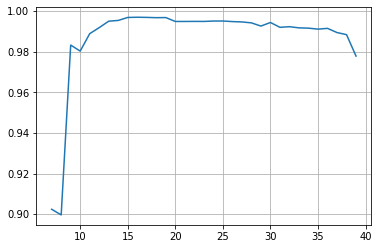

In [96]:
dtest = np.arange(7,40).astype(int)
ntest = len(dtest)
rsq = np.zeros(ntest)

# Loop over model orders
for i, d in enumerate(dtest):
    
    # Construct the transform class
    dct = DCTTrans(d=d)
    
    # Fit and transform on the training data
    Ztr = dct.fit_transform(xtr)
    
    # Fit the model on the transform
    reg = LinearRegression()
    reg.fit(Ztr,ytr)

    # Transform the test data
    Zts = dct.transform(xts)
        
    # Score on the test    
    yhat = reg.predict(Zts)
    rsq[i] = r2_score(yts,yhat)
    
plt.plot(dtest, rsq)
plt.grid()


We will retrain on the optimal model order

In [97]:
iopt = np.argmax(rsq)
dopt = dtest[iopt]

# Construct the transform class and re-fit
dct = DCTTrans(d=dopt)
Ztr = dct.fit_transform(xtr)

# Fit the model on the transform
reg = LinearRegression()
reg.fit(Ztr,ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Then, the plotting is also similar.

(0, 250)

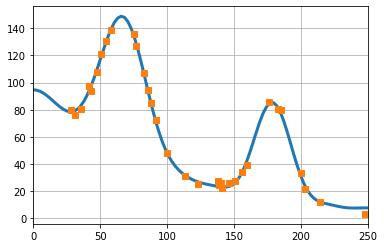

In [98]:
xp = np.linspace(0,250,100)
Zp = dct.transform(xp)
yp = reg.predict(Zp)

plt.plot(xp, yp, '-', lw=3)
plt.plot(xts, yts, 's')
plt.grid()
plt.xlim([0,250])

## In-Class Exercise

Now try to write your own transform class for the model:

    yhat = w[0] + \sum_{j=1}^{d}  w[j]*sigmoid( c*(x/xmax - j/d) )  
    
where 

    sigmoid(u) = 1/(1+exp(-u))
    
First create the fixed tranform function with `xmax=250` and `c=5`.
Then, create a trainable class where `xmax` is he maximum value in the data, but `c` is still fixed.


In [84]:
# TODO